In [1]:
# import libraries
%pylab inline
#%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm.autonotebook import tqdm
from pandas.tseries.holiday import *

Populating the interactive namespace from numpy and matplotlib


<ipython-input-1-0e64e29b5e30>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Open data
data = pd.read_csv('NYC_2014-2016.csv', index_col=0)
data_april = data.iloc[:-1464, :]
data_may = data.iloc[:-720]
data_may

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2014-01-01 00:00:00,87,146,70,113,367,645,589,799,948,321,...,9,0,5,89,10,35,9,106,22,71
2014-01-01 01:00:00,92,184,93,153,539,604,490,635,667,225,...,24,0,3,22,2,5,0,87,0,44
2014-01-01 02:00:00,108,165,55,151,443,571,465,499,455,124,...,27,0,3,23,1,1,0,39,0,1
2014-01-01 03:00:00,77,108,32,112,372,533,442,370,307,101,...,57,0,0,3,2,1,0,5,1,0
2014-01-01 04:00:00,47,79,22,77,213,383,296,319,261,87,...,38,0,1,9,1,8,0,29,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,106,167,171,88,293,401,433,284,428,222,...,1,5,9,347,304,104,15,172,17,103
2016-05-31 20:00:00,99,166,165,65,301,350,404,351,444,190,...,0,16,10,336,271,154,23,284,116,111
2016-05-31 21:00:00,84,173,107,78,256,340,416,426,493,173,...,0,37,5,289,306,167,26,212,84,130
2016-05-31 22:00:00,83,98,127,94,174,345,415,411,490,144,...,1,20,9,392,299,123,12,222,53,123


### 1. Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте $Q_{may}$  — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.

In [3]:
from sklearn.linear_model import Lasso, Ridge, LassoLarsIC, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
def get_features(data):
    '''This function returen pandas Data Frame with new features. Input data must have column "y"'''
    data['trend'] = np.log(data['y'].values + 1) - np.log(data['y'].shift(1).values + 1)
    data['diff'] = data['y'] - data['y'].shift(1)
    data['sum_24'] = data['y'].rolling(24).sum()
    data['sum_168'] = data['y'].rolling(168).sum()
    data['median_168'] = data['y'].rolling(168).median()
    data['max_72'] = data['y'].rolling(72).max()
    data['week_max'] = data['y'].rolling(168).max()
    data['min_72'] = data['y'].rolling(72).min()
    data['week_min'] = data['y'].rolling(168).min()
    data['diff_max_min'] = data['week_max'] - data['week_min']
    data['exp_ma_24'] = data['y'].ewm(span=24, min_periods=24, adjust=False).mean()
    data['exp_ma_72'] = data['y'].ewm(span=72, min_periods=72, adjust=False).mean()
    data['exp_ma_168'] = data['y'].ewm(span=168, min_periods=168, adjust=False).mean()
    data['diff_ema'] = data['exp_ma_168'] - data['exp_ma_24']
    data['week_std'] = data['y'].rolling(168).std()
    # Add shift data
    for shift in [24, 48, 72, 168]:
        data['shift_{}'.format(shift)] = data['y'].shift(shift)

In [5]:
# Create new df for date features
df_feats = pd.DataFrame(np.zeros((data.shape[0], 1)), columns=['holiday'])
df_feats.index = pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')
df_feats.shape

# Add holidays to data
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2014, 1, 1), end=datetime(2016, 6, 30)) 
# Сonvert it to the needed format and substitute it in the data
h_days = pd.to_datetime(holidays).strftime('%Y-%m-%d')
for h in h_days:
    df_feats.holiday[h] = 1
    
# Add numbers of hours, weekday and weekends
df_feats["hour"] = df_feats.index.hour
df_feats["weekday"] = df_feats.index.weekday
df_feats["is_weekend"] = df_feats.weekday.isin([5, 6]) * 1
df_feats['day'] = df_feats.index.day
df_feats['week'] = df_feats.index.week
df_feats.sample(3)

,holiday,hour,weekday,is_weekend,day,week
2015-09-15 15:00:00,0.0,15,1,0,15,38
2014-05-04 02:00:00,0.0,2,6,1,4,18
2015-08-16 17:00:00,0.0,17,6,1,16,33


In [6]:
# Create constant and new regression features matrix for seasons and trands to all clusters regions
pi = np.math.pi
K = 10
reg_feature = np.zeros((len(data), K*4)) 
# Let's fill the array with features
for k in range(K):
    for i in range(len(reg_feature)):   
        # Week cicle
        reg_feature[i, k*4] = np.sin((i+1)*2*pi*(k+1)/168.)
        reg_feature[i, k*4+1] = np.cos((i+1)*2*pi*(k+1)/168.)
        # Year cicle
        reg_feature[i, k*4+2] = np.sin((i+1)*2*pi*(k+1)/8760)
        reg_feature[i, k*4+3] = np.cos((i+1)*2*pi*(k+1)/8760)

# Create Data Frame
cols = []
for k in range(10):
    cols.append('sin_week_{}'.format(k*4))
    cols.append('cos_week_{}'.format(k*4+1))
    cols.append('sin_year_{}'.format(k*4+2))
    cols.append('cos_year_{}'.format(k*4+3))
    
# Create Data Frame
reg_feature = pd.DataFrame(reg_feature, columns=cols)
reg_feature.index = pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')
reg_feature = pd.concat([reg_feature, df_feats], axis=1)
print(reg_feature.shape)
reg_feature.head(3)

(21888, 46)


,sin_week_0,cos_week_1,sin_year_2,cos_year_3,sin_week_4,cos_week_5,sin_year_6,cos_year_7,sin_week_8,cos_week_9,...,sin_week_36,cos_week_37,sin_year_38,cos_year_39,holiday,hour,weekday,is_weekend,day,week
2014-01-01 00:00:00,0.037391,0.999301,0.000717,1.000000,0.074730,0.997204,0.001435,0.999999,0.111964,0.993712,...,0.365341,0.930874,0.007173,0.999974,1.0,0,2,0,1,1
2014-01-01 01:00:00,0.074730,0.997204,0.001435,0.999999,0.149042,0.988831,0.002869,0.999996,0.222521,0.974928,...,0.680173,0.733052,0.014345,0.999897,1.0,1,2,0,1,1
2014-01-01 02:00:00,0.111964,0.993712,0.002152,0.999998,0.222521,0.974928,0.004304,0.999991,0.330279,0.943883,...,0.900969,0.433884,0.021516,0.999769,1.0,2,2,0,1,1


In [7]:
import warnings
warnings.filterwarnings("ignore")

In [191]:
# Rolling mean, max, min, ; ewm(alpha=0.1, adjust=False).mean()
# diff 1, diff 168,  difference between MA
Qmay = 0
Qmay_l = 0
Qmay_r = 0

for reg in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_may = reg_feature.iloc[:data_may.shape[0]-6, :]
        reg_feats_may['y'] = shifted_data.iloc[:reg_feats_may.shape[0], reg].values
        # Add new features: sum, median, max and min, exponential weighted MA, standart deviation
        get_features(reg_feats_may)
        # Split y to train and test
        y_train = reg_feats_may['y'].iloc[168:-739]
        y_test = reg_feats_may['y'].iloc[-739:]
        # Delete real values
        reg_feats_may.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_may[168:-739].values
        X_test = reg_feats_may[-739:].values
        # Initialize models
        model_r = Ridge().fit(X_train, y_train)
        model_l = Lasso().fit(X_train, y_train)
        LarsL = LassoLarsIC(criterion='aic', eps = 1e-4).fit(X_train, y_train)
        elast = ElasticNet(alpha=0.1, l1_ratio=0.6).fit(X_train, y_train)
        # Get predict
        pred_r = model_r.predict(X_test)
        pred_l = model_l.predict(X_test)
        pred_lars = LarsL.predict(X_test)
        pred_elast = elast.predict(X_test)
        # Change negative values to 0
        pred_r = np.where(pred_r>0, pred_r, 0)
        pred_l = np.where(pred_l>0, pred_l, 0)
        pred_elast = np.where(pred_elast>0, pred_elast, 0)
        # Calculate errors
        Qmay += sum(abs(y_test.values - pred_elast))
        Qmay_l += sum(abs(y_test.values - pred_l))
        Qmay_r += sum(abs(y_test.values - pred_r))
        
    print('Qmay ElasticNet - {} ;     Qmay Lasso - {} ;   Qmay Ridge - {}'.format(Qmay/739/6/(reg+1), Qmay_l/739/6/(reg+1), Qmay_r/739/6/(reg+1)))

Qmay ElasticNet - 9.300160049438551 ;     Qmay Lasso - 10.229868806937855 ;   Qmay Ridge - 8.6679334869241
Qmay ElasticNet - 11.900177007437323 ;     Qmay Lasso - 12.466073389791818 ;   Qmay Ridge - 11.307563637523925
Qmay ElasticNet - 11.728622493799 ;     Qmay Lasso - 12.243180182801211 ;   Qmay Ridge - 11.347616058393895
Qmay ElasticNet - 10.88784214539219 ;     Qmay Lasso - 11.47915163952032 ;   Qmay Ridge - 10.514131071301522
Qmay ElasticNet - 12.354908826814533 ;     Qmay Lasso - 12.873003012179193 ;   Qmay Ridge - 11.938376880286961
Qmay ElasticNet - 14.590514528595216 ;     Qmay Lasso - 15.107819147380923 ;   Qmay Ridge - 14.277423732987186
Qmay ElasticNet - 16.75564088690711 ;     Qmay Lasso - 17.259098512033372 ;   Qmay Ridge - 16.494030550453946
Qmay ElasticNet - 18.874525200862774 ;     Qmay Lasso - 19.364163492000785 ;   Qmay Ridge - 18.8104232958697
Qmay ElasticNet - 21.61225278892189 ;     Qmay Lasso - 21.998828203589948 ;   Qmay Ridge - 21.42212980187556
Qmay ElasticNet

Qmay ElasticNet - 19.896237949614648 ;     Qmay Lasso - 20.17390287795196 ;   Qmay Ridge - 19.911317436291043
Qmay ElasticNet - 19.679438724486037 ;     Qmay Lasso - 19.954167528117207 ;   Qmay Ridge - 19.693722749266435
Qmay ElasticNet - 19.45789362801623 ;     Qmay Lasso - 19.733449038740112 ;   Qmay Ridge - 19.47119796874569
Qmay ElasticNet - 19.23340763187857 ;     Qmay Lasso - 19.50950524619906 ;   Qmay Ridge - 19.245549963171204
Qmay ElasticNet - 19.0437367246029 ;     Qmay Lasso - 19.320029485503763 ;   Qmay Ridge - 19.055544957417172
Qmay ElasticNet - 18.87812908357113 ;     Qmay Lasso - 19.153451208177337 ;   Qmay Ridge - 18.889937851387586
Qmay ElasticNet - 18.677373006291564 ;     Qmay Lasso - 18.95169898901102 ;   Qmay Ridge - 18.68873318173958
Qmay ElasticNet - 18.476148105414797 ;     Qmay Lasso - 18.750807562581734 ;   Qmay Ridge - 18.48689367163472
Qmay ElasticNet - 18.27459851606478 ;     Qmay Lasso - 18.550671596027218 ;   Qmay Ridge - 18.284541323164156
Qmay ElasticN

In [194]:
Qmay/(739*102*6), Qmay_l/(739*102*6), Qmay_r/(739*102*6)

(16.256125923154645, 16.548159407365166, 16.22513105089042)

### 2. Попробуйте добавить признаки. Используйте идеи, которые мы предложили, или какие-то свои. Обучайте обновлённые модели на данных до апреля 2016 включительно и считайте качество новых прогнозов на мае. Удаётся ли вам улучшить качество? Не нужно ли увеличить сложность регрессионной модели? Если добавляемый признак не улучшает качество, всё равно оставьте доказательства этому в ноутбуке, чтобы ваши коллеги это видели при проверке. 

In [8]:
def get_FFT_feats(data):
    # Create 2 FFT features
    np_data = data['y'].values
    n = len(np_data)  
    f_hat = np.fft.fft(np_data, n)                       # Compute FFT
    PSD = f_hat * np.conj(f_hat) / n                     # Power spectrum
    freq = np.arange(n)                                  # x-axis
    L = np.arange(1, np.floor(n/2), dtype='int') 
    
    sortd = np.sort(np.abs(PSD))[::-1]
    # Use the PSD to filter out noise
    indeces = PSD > sortd[24]                             #Find all freqs with large
    PSD_clean = PSD * indeces                            # Zero out all others
    fhat = indeces * f_hat                               # Zero out small Fourier coefs in Y
    inv_fft_complex = np.fft.ifft(fhat)                  # Inverse FFT for filtered time signal
    inv_fft = np.abs(inv_fft_complex)                    # Change complex type to real type  abs = sqrt(a^2+b^2)
    # Second feat fft
    indeces_bot = PSD > sortd[168]                      
    PSD_clean_bot = PSD * indeces_bot                    # Zero out all others
    fhat_bot = indeces_bot * f_hat                       # Zero out small Fourier coefs in Y
    inv_fft_bot_complex = np.fft.ifft(fhat_bot)          # Inverse FFT for filtered time signal
    inv_fft_bot = np.abs(inv_fft_bot_complex)            # Change complex type to real type

    data['inv_fft'] = inv_fft
    data['inv_fft_bot'] = inv_fft_bot

1. Расстояние по счётчику (среднее)
2. Стоимость поездки по счётчику (среднее)
3. Доплата за поездки в пиковые часы и ночью (среднее)
4. Время поездки (количество)

In [9]:
# Download new generated features
new_feats = []
for i in range(3):
    name = '{}_feats.csv'.format(2014+i)
    new_feats.append(np.genfromtxt(name, delimiter=','))

In [10]:
# 4 new features from our row data
columns = ['mean_trip_distance', 'mean_fare_amount', 'mean_surcharge', 'trip_duration']
# Connect all
feats_2014_2016 = np.concatenate([new_feats[0], new_feats[1], new_feats[2]])   # (2232576, 4)
# Splits by regions
feats_all = feats_2014_2016.reshape(102, 21888, 4)
feats_all.shape

(102, 21888, 4)

#### С новыми признаками

In [192]:
# Let's calculate regression error with new created features from row data
Q_may_new = 0
Q_may_l_new = 0
#Q_may_rf_new = 0
Q_ridge_new = 0
for region in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_may = reg_feature.iloc[:data_may.shape[0]-6, :]
        reg_feats_may['y'] = shifted_data.iloc[:reg_feats_may.shape[0], region].values
        # Add new features: sum, median, max and min, exponential weighted MA, standart deviation and shift plus FFT
        get_features(reg_feats_may)
        
        # Add new features from row data
        new_fts = pd.DataFrame(feats_all[region, :, :], columns=columns,
                      index=pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')).shift(-lag)
        # Connect both Data Frame
        reg_feats_may = pd.concat([reg_feats_may, new_fts[:reg_feats_may.shape[0]]], axis=1)
        reg_feats_may['mean_week_tdist'] = reg_feats_may['mean_trip_distance'].ewm(span=168, min_periods=168, adjust=False).mean()
        reg_feats_may['max_week_tdist'] = reg_feats_may['mean_trip_distance'].rolling(168).max()
        reg_feats_may['min_week_tdist'] = reg_feats_may['mean_trip_distance'].rolling(168).max()
        reg_feats_may['mean_week_tdurat'] = reg_feats_may['trip_duration'].ewm(span=168, min_periods=168, adjust=False).mean()
        reg_feats_may['max_week_tdurat'] = reg_feats_may['trip_duration'].rolling(168).max()
        reg_feats_may['min_week_tdurat'] = reg_feats_may['trip_duration'].rolling(168).max()
  
        # Split y to train and test
        y_train = reg_feats_may['y'].iloc[168:-739]
        y_test = reg_feats_may['y'].iloc[-739:]
        # Delete real values
        reg_feats_may.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_may[168:-739].values
        X_test = reg_feats_may[-739:].values
        # Initialize models
        model_r = Ridge().fit(X_train, y_train)
        model_l = Lasso().fit(X_train, y_train)
        LarsL = LassoLarsIC(criterion='aic', eps = 1e-4).fit(X_train, y_train)
        elast = ElasticNet(alpha=0.1, l1_ratio=0.6).fit(X_train, y_train)
        # Get predict
        pred_r = model_r.predict(X_test)
        pred_l = model_l.predict(X_test)
        pred_lars = LarsL.predict(X_test)
        pred_elast = elast.predict(X_test)
        # Change negative values to 0
        pred_l = np.where(pred_l>0, pred_l, 0)
        pred_elast = np.where(pred_elast>0, pred_elast, 0)
        # Calculate errors
        Q_may_new += sum(abs(y_test.values - pred_elast))
        Q_may_l_new += sum(abs(y_test.values - pred_l))
        Q_ridge_new += sum(abs(y_test.values - pred_r))
        
    print('Q Ridge - {}; Qmay ElasticNet - {} ; Qmay Lasso - {}'.format(Q_ridge_new/739/6/(region+1), Q_may_new/739/6/(region+1), Q_may_l_new/739/6/(region+1)))

Q Ridge - 8.715352898699383; Qmay ElasticNet - 9.232370957447856 ; Qmay Lasso - 10.234552620717011
Q Ridge - 11.173089132134116; Qmay ElasticNet - 11.740829661029808 ; Qmay Lasso - 12.385775324991464
Q Ridge - 11.31715807122665; Qmay ElasticNet - 11.61827353493011 ; Qmay Lasso - 12.18976601639285
Q Ridge - 10.500227853090996; Qmay ElasticNet - 10.804696668418993 ; Qmay Lasso - 11.444169114477559
Q Ridge - 11.947575213055604; Qmay ElasticNet - 12.286704320390442 ; Qmay Lasso - 12.84738191274845
Q Ridge - 14.29250008031655; Qmay ElasticNet - 14.510934882920367 ; Qmay Lasso - 15.07134522718126
Q Ridge - 16.537731880838052; Qmay ElasticNet - 16.65411016542314 ; Qmay Lasso - 17.21677527431297
Q Ridge - 18.807546434565698; Qmay ElasticNet - 18.784027648207353 ; Qmay Lasso - 19.330465015478143
Q Ridge - 21.48690898367439; Qmay ElasticNet - 21.54672989666328 ; Qmay Lasso - 22.021910687033298
Q Ridge - 21.206901696910386; Qmay ElasticNet - 21.31705724571107 ; Qmay Lasso - 21.810237462045738
Q R

Q Ridge - 18.696709959836546; Qmay ElasticNet - 18.473784146272422 ; Qmay Lasso - 18.563830289970934
Q Ridge - 18.498433493632; Qmay ElasticNet - 18.27828526796983 ; Qmay Lasso - 18.371539918858648
Q Ridge - 18.309703424016924; Qmay ElasticNet - 18.09248730625783 ; Qmay Lasso - 18.189155410910235
Q Ridge - 18.12629253188919; Qmay ElasticNet - 17.91102325331625 ; Qmay Lasso - 18.009658260396122
Q Ridge - 17.94387444054935; Qmay ElasticNet - 17.731582380724884 ; Qmay Lasso - 17.834598806502516
Q Ridge - 17.774879587071894; Qmay ElasticNet - 17.564518113209385 ; Qmay Lasso - 17.672013116253204
Q Ridge - 17.595411246425765; Qmay ElasticNet - 17.387424532906397 ; Qmay Lasso - 17.498372774654076
Q Ridge - 17.428202041017286; Qmay ElasticNet - 17.22177876367835 ; Qmay Lasso - 17.336515257252998
Q Ridge - 17.255876756373706; Qmay ElasticNet - 17.052337711295745 ; Qmay Lasso - 17.169120774351253
Q Ridge - 17.085665266298054; Qmay ElasticNet - 16.884980015744244 ; Qmay Lasso - 17.00412718282729


In [195]:
print(Q_may_l_new/(739*102*6), Q_may_new/(739*102*6), Q_ridge_new/(739*102*6))

16.55574603460057 16.416723235956294 16.635143478356074


#### Без новых признаков, но с сезонностью

In [17]:
# Let's calculate regression error with new created features from row data
Q_may_new_2 = 0
Q_may_l_new_2 = 0
Q_ridge_new_2 = 0
for region in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_may = reg_feature.iloc[:data_may.shape[0]-6, :]
        reg_feats_may['y'] = shifted_data.iloc[:reg_feats_may.shape[0], region].values
        # Add new features: sum, median, max and min, exponential weighted MA, standart deviation and shift plus FFT
        get_features(reg_feats_may)
        get_FFT_feats(reg_feats_may)
        # Split y to train and test
        y_train = reg_feats_may['y'].iloc[168:-739]
        y_test = reg_feats_may['y'].iloc[-739:]
        # Delete real values
        reg_feats_may.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_may[168:-739].values
        X_test = reg_feats_may[-739:].values
        # Initialize models
        model_r = Ridge().fit(X_train, y_train)
        model_l = Lasso().fit(X_train, y_train)
        LarsL = LassoLarsIC(criterion='aic', eps = 1e-4).fit(X_train, y_train)
        elast = ElasticNet(alpha=0.1, l1_ratio=0.6).fit(X_train, y_train)
        # Get predict
        pred_r = model_r.predict(X_test)
        pred_l = model_l.predict(X_test)
        pred_lars = LarsL.predict(X_test)
        pred_elast = elast.predict(X_test)
        # Change negative values to 0
        pred_l = np.where(pred_l>0, pred_l, 0)
        pred_elast = np.where(pred_elast>0, pred_elast, 0)
        # Calculate errors
        Q_may_new_2 += sum(abs(y_test.values - pred_elast))
        Q_may_l_new_2 += sum(abs(y_test.values - pred_l))
        Q_ridge_new_2 += sum(abs(y_test.values - pred_r))

In [18]:
print(Q_may_l_new_2/(739*102*6), Q_may_new_2/(739*102*6), Q_ridge_new_2/(739*102*6))

21.936998752040875 21.741752876749537 21.720574608536655


<AxesSubplot:>

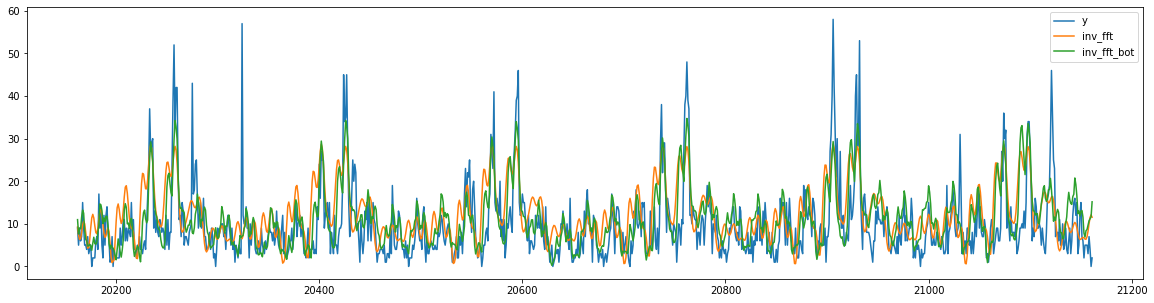

In [15]:
# Test FFT features
dt_test = pd.DataFrame(data.iloc[:reg_feats_may.shape[0], 90].values, columns=['y'])

get_FFT_feats(dt_test)
dt_test[-1000:].plot(figsize=(20, 5))

In [16]:
dt_test.head()

,y,inv_fft,inv_fft_bot
0,42,10.167414,18.700695
1,147,8.723457,18.573228
2,204,8.044148,18.774830
3,169,8.552090,18.571410
4,127,10.008891,19.714993


### 3. Когда вы примете решение остановиться и перестать добавлять признаки, постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза

In [19]:
# Let's calculate regression error with new created features from row data
Q_may_new_1 = 0
Q_may_l_new_1 = 0
Q_ridge_new_1 = 0
for region in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_may = reg_feature.iloc[:data_may.shape[0]-6, :]
        reg_feats_may['y'] = shifted_data.iloc[:reg_feats_may.shape[0], region].values
        # Add new features: sum, median, max and min, exponential weighted MA, standart deviation and shift plus FFT
        get_features(reg_feats_may)
        
        # Add new features from row data
        new_fts = pd.DataFrame(feats_all[region, :, :], columns=columns,
                      index=pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')).shift(-lag)
        # Connect both Data Frame
        reg_feats_may = pd.concat([reg_feats_may, new_fts[:reg_feats_may.shape[0]]], axis=1)
  
        # Split y to train and test
        y_train = reg_feats_may['y'].iloc[168:-739]
        y_test = reg_feats_may['y'].iloc[-739:]
        # Delete real values
        reg_feats_may.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_may[168:-739].values
        X_test = reg_feats_may[-739:].values
        # Initialize models
        model_r = Ridge().fit(X_train, y_train)
        model_l = Lasso().fit(X_train, y_train)
        LarsL = LassoLarsIC(criterion='aic', eps = 1e-4).fit(X_train, y_train)
        elast = ElasticNet(alpha=0.1, l1_ratio=0.6).fit(X_train, y_train)
        # Get predict
        pred_r = model_r.predict(X_test)
        pred_l = model_l.predict(X_test)
        pred_lars = LarsL.predict(X_test)
        pred_elast = elast.predict(X_test)
        # Change negative values to 0
        pred_l = np.where(pred_l>0, pred_l, 0)
        pred_elast = np.where(pred_elast>0, pred_elast, 0)
        # Calculate errors
        Q_may_new_1 += sum(abs(y_test.values - pred_elast))
        Q_may_l_new_1 += sum(abs(y_test.values - pred_l))
        Q_ridge_new_1 += sum(abs(y_test.values - pred_r))

In [20]:
print(Q_may_l_new_1/(739*102*6), Q_may_new_1/(739*102*6), Q_ridge_new_1/(739*102*6))

16.537196505665595 16.25875796120476 16.447966234601427


Странно, но качество практический не изменилось, даже стало немного хуже

### 4. Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате

Попробую c добавления дополнительных признаков

In [28]:
# Rolling mean, max, min, ; ewm(alpha=0.1, adjust=False).mean()
# diff 1, diff 168,  difference between MA
Q_june = 0
Q_june_r = 0
Q_june_rf = 0
# Create arrays for predictions
predict_rf_new = np.zeros((6, 715, 102))
predict_elast_new = np.zeros((6, 715, 102))

for region in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_june = reg_feature.iloc[:data.shape[0]-6, :]
        reg_feats_june['y'] = shifted_data.iloc[:reg_feats_june.shape[0], region].values
        # Add new features: sum, median, max and min, exponential weighted MA, standart deviation
        get_features(reg_feats_june)
        # Add new features from row data
        new_fts = pd.DataFrame(feats_all[region, :, :], columns=columns,
                      index=pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')).shift(-lag)
        # Connect both Data Frame
        reg_feats_june = pd.concat([reg_feats_june, new_fts[:reg_feats_june.shape[0]]], axis=1)
        
        # Split y to train and test
        y_train = reg_feats_june['y'].iloc[168:-715]
        y_test = reg_feats_june['y'].iloc[-715:]
        # Delete real values
        reg_feats_june.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_june[168:-715].values
        X_test = reg_feats_june[-715:].values
        # Initialize models
        rf_reg = RandomForestRegressor(n_estimators=150, random_state=0, n_jobs=-1).fit(X_train, y_train)
        model_r = Ridge().fit(X_train, y_train)
        model_l = Lasso().fit(X_train, y_train)
        LarsL = LassoLarsIC(criterion='aic', eps = 1e-4).fit(X_train, y_train)
        elast = ElasticNet(alpha=0.1, l1_ratio=0.6).fit(X_train, y_train)
        # Get predict
        pred_rf_reg = rf_reg.predict(X_test)
        pred_r = model_r.predict(X_test)
        pred_l = model_l.predict(X_test)
        pred_lars = LarsL.predict(X_test)
        pred_elast = elast.predict(X_test)
        # Change negative values to 0
        predict_rf_new[lag-1, :, region] = np.where(pred_rf_reg>0, pred_rf_reg, 0)
        pred_l = np.where(pred_l>0, pred_l, 0)
        predict_elast_new[lag-1, :, region] = np.where(pred_elast>0, pred_elast, 0)
        # Calculate errors
        Q_june += sum(abs(y_test.values - predict_elast_new[lag-1, :, region]))
        Q_june_r += sum(abs(y_test.values - pred_r))
        Q_june_rf += sum(abs(y_test.values - predict_rf_new[lag-1, :, region]))
        
    print('Q ElasticNet - {} ;     Q Ridge - {} ;   Q Rand Forest Reg - {}'.format(Q_june/715/6/(region+1), 
                                                                                   Q_june_r/715/6/(region+1), 
                                                                                   Q_june_rf/715/6/(region+1)))

Q ElasticNet - 9.877619607778872 ;     Q Ridge - 9.482946830448052 ;   Q Rand Forest Reg - 6.597241647241646
Q ElasticNet - 11.54841450129863 ;     Q Ridge - 11.388700457542015 ;   Q Rand Forest Reg - 8.527213675213677
Q ElasticNet - 11.351592723269972 ;     Q Ridge - 11.41347836844824 ;   Q Rand Forest Reg - 8.087452473452474
Q ElasticNet - 10.431641935242391 ;     Q Ridge - 10.442435174024077 ;   Q Rand Forest Reg - 7.371531857031855
Q ElasticNet - 11.713289755128146 ;     Q Ridge - 11.656931759352803 ;   Q Rand Forest Reg - 8.639620823620822
Q ElasticNet - 13.91064179749045 ;     Q Ridge - 13.96147345440892 ;   Q Rand Forest Reg - 10.409066822066823
Q ElasticNet - 15.860824916017634 ;     Q Ridge - 16.091072423240828 ;   Q Rand Forest Reg - 11.863309579309577
Q ElasticNet - 18.158084687242397 ;     Q Ridge - 18.572431136612867 ;   Q Rand Forest Reg - 13.456871017871016
Q ElasticNet - 20.679976130790298 ;     Q Ridge - 21.102293289236698 ;   Q Rand Forest Reg - 15.374603988603987
Q E

Q ElasticNet - 19.477350459075456 ;     Q Ridge - 19.921875168979764 ;   Q Rand Forest Reg - 13.543834260554261
Q ElasticNet - 19.241328178472482 ;     Q Ridge - 19.683386118547023 ;   Q Rand Forest Reg - 13.374039197644459
Q ElasticNet - 19.036826098353448 ;     Q Ridge - 19.472604701378803 ;   Q Rand Forest Reg - 13.218193220920488
Q ElasticNet - 18.818101039889825 ;     Q Ridge - 19.248238415760376 ;   Q Rand Forest Reg - 13.060679178371483
Q ElasticNet - 18.605566777673126 ;     Q Ridge - 19.029937281957267 ;   Q Rand Forest Reg - 12.904862175798888
Q ElasticNet - 18.420807838478378 ;     Q Ridge - 18.839923568204817 ;   Q Rand Forest Reg - 12.77532987567988
Q ElasticNet - 18.274649828114775 ;     Q Ridge - 18.688999887414496 ;   Q Rand Forest Reg - 12.666614310243945
Q ElasticNet - 18.080240311685554 ;     Q Ridge - 18.489429593436665 ;   Q Rand Forest Reg - 12.524592207250748
Q ElasticNet - 17.88348112755333 ;     Q Ridge - 18.287563130746005 ;   Q Rand Forest Reg - 12.3799578547

In [29]:
Q_june/715/6/102, Q_june_r/715/6/102, Q_june_rf/715/6/102

(15.82107931593027, 16.196310823680587, 10.888413394883978)

Without new features

In [234]:
# Rolling mean, max, min, ; ewm(alpha=0.1, adjust=False).mean()
# diff 1, diff 168,  difference between MA
Qjune = 0
Qjune_r = 0
Qjune_rf = 0
Qjune_lars = 0
Qjune_l = 0
# Create arrays for predictions
predict_rf = np.zeros((6, 715, 102))
predict_elast = np.zeros((6, 715, 102))

for region in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_june = reg_feature.iloc[:data.shape[0]-6, :]
        reg_feats_june['y'] = shifted_data.iloc[:reg_feats_june.shape[0], region].values
        # Add new features: sum, median, max and min, exponential weighted MA, standart deviation
        get_features(reg_feats_june)
        
        # Split y to train and test
        y_train = reg_feats_june['y'].iloc[168:-715]
        y_test = reg_feats_june['y'].iloc[-715:]
        # Delete real values
        reg_feats_june.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_june[168:-715].values
        X_test = reg_feats_june[-715:].values
        # Initialize models
        rf_reg = RandomForestRegressor(n_estimators=150, random_state=0, n_jobs=-1).fit(X_train, y_train)
        model_r = Ridge().fit(X_train, y_train)
        model_l = Lasso().fit(X_train, y_train)
        LarsL = LassoLarsIC(criterion='aic', eps = 1e-4).fit(X_train, y_train)
        elast = ElasticNet(alpha=0.1, l1_ratio=0.6).fit(X_train, y_train)
        # Get predict
        pred_rf_reg = rf_reg.predict(X_test)
        pred_r = model_r.predict(X_test)
        pred_l = model_l.predict(X_test)
        pred_lars = LarsL.predict(X_test)
        pred_elast = elast.predict(X_test)
        # Change negative values to 0
        predict_rf[lag-1, :, region] = np.where(pred_rf_reg>0, pred_rf_reg, 0)
        pred_l = np.where(pred_l>0, pred_l, 0)
        predict_elast[lag-1, :, region] = np.where(pred_elast>0, pred_elast, 0)
        # Calculate errors
        Qjune += sum(abs(y_test.values - predict_elast[lag-1, :, region]))
        Qjune_lars += sum(abs(y_test.values - pred_lars)) 
        Qjune_r += sum(abs(y_test.values - pred_r))
        Qjune_rf += sum(abs(y_test.values - predict_rf[lag-1, :, region]))
        Qjune_l += sum(abs(y_test.values - pred_l))

Q ElasticNet - 7.361317915507899 ;     Q Ridge - 7.304044640900037 ;   Q Rand Forest Reg - 5.289075369075369
Q ElasticNet - 8.95494959820214 ;     Q Ridge - 9.032619086194751 ;   Q Rand Forest Reg - 7.038808857808859
Q ElasticNet - 8.782757564097887 ;     Q Ridge - 8.991994380648885 ;   Q Rand Forest Reg - 6.754810152810152
Q ElasticNet - 8.157780475137278 ;     Q Ridge - 8.310065348828871 ;   Q Rand Forest Reg - 6.143669386169386


KeyboardInterrupt: 

In [31]:
Qjune/715/6/102, Qjune_r/715/6/102, Qjune_rf/715/6/102, Qjune_l/715/6/102, Qjune_lars/715/6/102

(15.824274807051406,
 16.19820339039049,
 10.837613602084188,
 16.2114460361016,
 16.08079306068809)

In [34]:
per = pd.date_range(start='5/31/2016', end='7/1/2016', freq='H', closed='left')
period = per[23:-6]

# Let's write answer to needed format region_year-month-day_hour_T
kaggle_pred = []
for region in range(102):
    reg = data.columns[region]
    for i in range(715):
        for T in range(6):
            kaggle_pred.append([str(reg)+'_'+str(period[i].strftime('%Y-%m-%d_'))+str(period[i].hour)+str('_')+str(T+1), 
                                predict_rf[T, i, region]])
            #print(str(reg)+'_'+str(period[i].strftime('%Y-%m-%d_%H'))+str('_')+str(T+1), predict_rf[T, i, region])
            
len(kaggle_pred)

437580

In [35]:
# Save 
kaggle = pd.DataFrame(kaggle_pred, columns=['id', 'y'])
kaggle['id'] = kaggle['id'].astype(str)
kaggle.to_csv('kaggle_june_new_feats.csv', sep=',', index=False)
kaggle

,id,y
0,1075_2016-05-31_23_1,27.186667
1,1075_2016-05-31_23_2,15.733333
2,1075_2016-05-31_23_3,5.746667
3,1075_2016-05-31_23_4,2.866667
4,1075_2016-05-31_23_5,2.880000
...,...,...
437575,2168_2016-06-30_17_2,22.413333
437576,2168_2016-06-30_17_3,16.700000
437577,2168_2016-06-30_17_4,28.046667
437578,2168_2016-06-30_17_5,4.960000


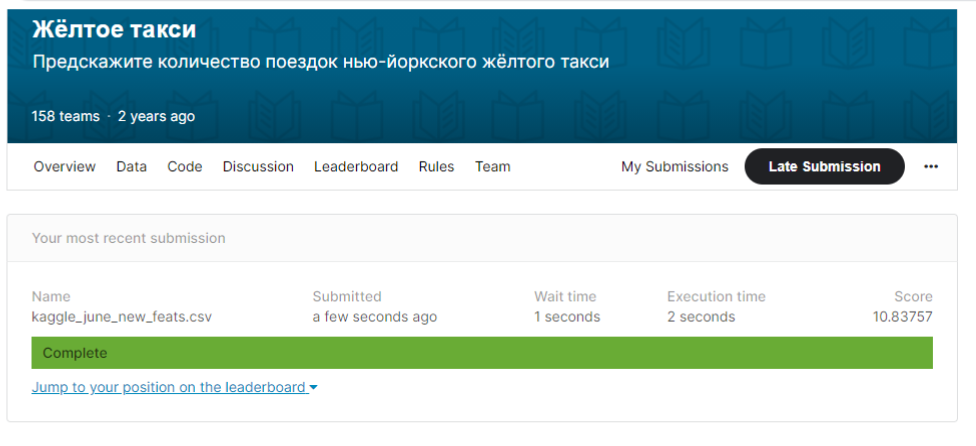

In [11]:
# Triple Exponential Moving Average (TEMA)
def TEMA(df, period):
    shape = df.shape
    # EMA 1(ts, period)
    df['1_EMA_{}'.format(period)] = df['y'].ewm(span=period, min_periods=period, adjust=False).mean()
    df.fillna(0, inplace=True)
    # EMA 2(EMA 1, period)
    df['2_EMA_{}'.format(period)] = df['1_EMA_{}'.format(period)].ewm(span=period, min_periods=period, adjust=False).mean()
    df.fillna(0, inplace=True)
    # EMA 3(EMA 2, period)
    df['3_EMA_{}'.format(period)] = df['2_EMA_{}'.format(period)].ewm(span=period, min_periods=period, adjust=False).mean()
    df.fillna(0, inplace=True)
    # TEMA = 3*EMA 1 - 3*EMA 2 + EMA 3
    df['TEMA_{}'.format(period)] = 3*df['1_EMA_{}'.format(period)].values - 3*df['2_EMA_{}'.format(period)].values + df['3_EMA_{}'.format(period)]
    # Difference between real and TEMA
    #df['Diff_TEMA_{}'.format(period)] = df['y'].shift(1) - df['TEMA_{}'.format(period)]
    # TEMA + errors with shift 1
    #df['TEMA_errors'.format(period)] = df['TEMA_{}'.format(period)] + df['Diff_TEMA_{}'.format(period)]
    # drop EMA
    df.drop(df.columns[shape[1]:-1], axis=1, inplace=True)


In [15]:
# Rolling mean, max, min, ; ewm(alpha=0.1, adjust=False).mean()
# diff 1, diff 168,  difference between MA
Qjune = 0
Qjune_r = 0
Qjune_rf = 0
Qjune_lars = 0
Qjune_l = 0
# Create arrays for predictions
predict_rf = np.zeros((6, 715, 102))
predict_elast = np.zeros((6, 715, 102))
errors_rf = np.zeros((6, 715, 102))
errors_elast = np.zeros((6, 715, 102))

for region in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_june = reg_feature.iloc[:data.shape[0]-6, :]
        reg_feats_june['y'] = shifted_data.iloc[:reg_feats_june.shape[0], region].values
        # Add new features: sum, median, max and min, exponential weighted MA, standart deviation
        get_features(reg_feats_june)
        TEMA(reg_feats_june, period=24)
        TEMA(reg_feats_june, period=168)
        
        # Split y to train and test
        y_train = reg_feats_june['y'].iloc[168:-715]
        y_test = reg_feats_june['y'].iloc[-715:]
        # Delete real values
        reg_feats_june.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_june[168:-715].values
        X_test = reg_feats_june[-715:].values
        # Initialize models
        rf_reg = RandomForestRegressor(n_estimators=150, random_state=0, n_jobs=-1).fit(X_train, y_train)
        model_r = Ridge().fit(X_train, y_train)
        model_l = Lasso().fit(X_train, y_train)
        LarsL = LassoLarsIC(criterion='aic', eps = 1e-4).fit(X_train, y_train)
        elast = ElasticNet(alpha=0.1, l1_ratio=0.6).fit(X_train, y_train)
        # Get predict
        pred_rf_reg = rf_reg.predict(X_test)
        pred_r = model_r.predict(X_test)
        pred_l = model_l.predict(X_test)
        pred_lars = LarsL.predict(X_test)
        pred_elast = elast.predict(X_test)
        # Change negative values to 0
        predict_rf[lag-1, :, region] = np.where(pred_rf_reg>0, pred_rf_reg, 0)
        pred_l = np.where(pred_l>0, pred_l, 0)
        predict_elast[lag-1, :, region] = np.where(pred_elast>0, pred_elast, 0)
        # Errors
        errors_rf[lag-1, :, region] = y_test.values - predict_rf[lag-1, :, region]
        errors_elast[lag-1, :, region] = y_test.values - predict_elast[lag-1, :, region]
        # Features for errors
        X_errors = reg_feature.iloc[-721:-6, :]
        # Create and fit model for errors
        err_model_rf = Ridge().fit(X_errors, errors_rf[lag-1, :, region])
        err_model_elast = Ridge().fit(X_errors, errors_elast[lag-1, :, region])
        # Predict for error
        err_pred_rf = err_model_rf.predict(X_errors)
        err_pred_elast = err_model_elast.predict(X_errors)
        # 
        new_pred_rf = predict_rf[lag-1, :, region] + err_pred_rf
        new_pred_elast = predict_elast[lag-1, :, region] + err_pred_elast
        # Calculate errors
        Qjune += sum(abs(y_test.values - predict_elast[lag-1, :, region]))
        Qjune_lars += sum(abs(y_test.values - pred_lars)) 
        Qjune_r += sum(abs(y_test.values - pred_r))
        Qjune_rf += sum(abs(y_test.values - predict_rf[lag-1, :, region]))
        Qjune_l += sum(abs(y_test.values - pred_l))
        
    print('Q ElasticNet - {} ;     Q Ridge - {} ;   Q Rand Forest Reg - {}'.format(Qjune/715/6/(region+1), 
                                                                                   Qjune_r/715/6/(region+1), 
                                                                                   Qjune_rf/715/6/(region+1)))
    print('New errors', sum(abs(y_test.values - new_pred_rf)), '  ', sum(abs(y_test.values - new_pred_elast)))

Q ElasticNet - 7.361317915507899 ;     Q Ridge - 7.304044640900037 ;   Q Rand Forest Reg - 5.289075369075369
New errors 3671.665642278862    4743.0438290736
Q ElasticNet - 8.95494959820214 ;     Q Ridge - 9.032619086194751 ;   Q Rand Forest Reg - 7.038808857808859
New errors 6105.7887098657775    7325.469968827716
Q ElasticNet - 8.782757564097887 ;     Q Ridge - 8.991994380648885 ;   Q Rand Forest Reg - 6.754810152810152
New errors 4386.774518799261    5792.543526279889
Q ElasticNet - 8.157780475137278 ;     Q Ridge - 8.310065348828871 ;   Q Rand Forest Reg - 6.143669386169386
New errors 3125.590850789433    4435.819050523834
Q ElasticNet - 9.22437350422548 ;     Q Ridge - 9.297161229324598 ;   Q Rand Forest Reg - 7.249867599067599
New errors 7862.587771300715    9266.48086997365
Q ElasticNet - 10.923731870765765 ;     Q Ridge - 11.050652032740324 ;   Q Rand Forest Reg - 8.802127946127948
New errors 11282.835952278603    13129.006755034552
Q ElasticNet - 12.624064510765493 ;     Q Ridg

Q ElasticNet - 18.035961928141653 ;     Q Ridge - 18.402626783328508 ;   Q Rand Forest Reg - 13.360555256709109
New errors 1509.5183255925356    2465.3414708380888
Q ElasticNet - 17.788551893666803 ;     Q Ridge - 18.157022003757522 ;   Q Rand Forest Reg - 13.152566418906046
New errors 1745.1083851058283    3243.7921468530794
Q ElasticNet - 17.55456918454478 ;     Q Ridge - 17.91880040881226 ;   Q Rand Forest Reg - 12.969776684221134
New errors 2307.0327905508257    3613.078164804774
Q ElasticNet - 17.688438198296115 ;     Q Ridge - 18.06405662203911 ;   Q Rand Forest Reg - 13.055625090061454
New errors 12435.530002923635    16788.9847453502
Q ElasticNet - 18.010685230077836 ;     Q Ridge - 18.39490060578882 ;   Q Rand Forest Reg - 13.246274198024205
New errors 16846.562841851624    23470.456138551977
Q ElasticNet - 18.21796751117557 ;     Q Ridge - 18.5870748143799 ;   Q Rand Forest Reg - 13.39940697119645
New errors 15542.02580552005    19992.839047545785
Q ElasticNet - 18.0448270331

In [16]:
Qjune/715/6/102, Qjune_r/715/6/102, Qjune_rf/715/6/102, Qjune_l/715/6/102, Qjune_lars/715/6/102

(12.620237961398804,
 12.875570604725922,
 9.031264683029391,
 13.043940027819849,
 12.789309071316541)

In [17]:
# # Save predict for
# for lag in range(1, 7):
#     name_rf = 'predict_june_rf_{}.csv'.format(lag)
#     name_errs_rf = 'errors_june_rf_{}.csv'.format(lag)
#     np.savetxt(name_rf, predict_rf[lag-1, :, :], delimiter=",")
#     np.savetxt(name_errs_rf, errors_rf[lag-1, :, :], delimiter=",")

In [12]:
# Open predict and errors
pred_june = np.zeros((6, 715, 102))
error_june = np.zeros((6, 715, 102))
for l in range(1, 7):
    name_rf = 'predict_june_rf_{}.csv'.format(l)
    name_errs_rf = 'errors_june_rf_{}.csv'.format(l)
    pred_june[l-1, :, :] = np.genfromtxt(name_rf, delimiter=',')
    error_june[l-1, :, :] = np.genfromtxt(name_errs_rf, delimiter=',')

Обычная регрессия для ошибки

In [26]:
# predict errors with regression
Q_err = 0
for reg in range(102):
    for l in range(1, 7):
        # real data
        shifted_data = data.shift(-l)
        # Change size for features to 06.01.2016 - 06.30.2016 17:00
        reg_feats_err = reg_feature.iloc[-722+l:-7+l, :]
        real_data = shifted_data.iloc[-721:-6, reg].values
        # Fit ridge
        err_model = Ridge().fit(reg_feats_err, error_june[l-1, :, reg])
        # Get predict
        pred_err = err_model.predict(reg_feats_err)
        # Add predict of error to predict in June
        last_pred = pred_june[l-1, :, reg] + pred_err
        # Calculate error
        Q_err = sum(abs(real_data - last_pred))

In [27]:
Q_err/715/102/6

0.006763284262497636

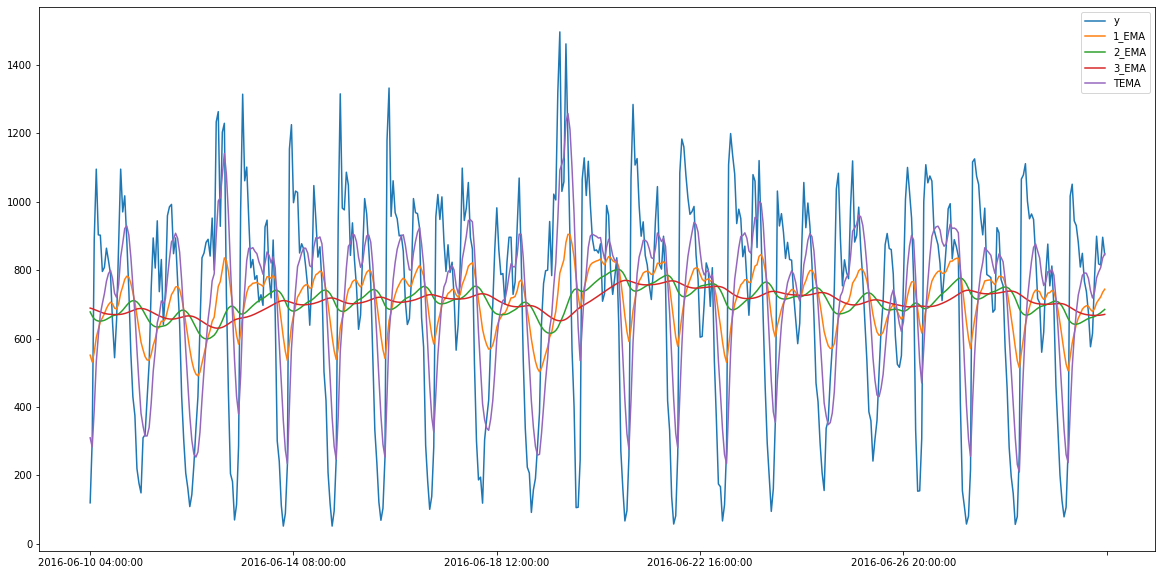

In [35]:
df = pd.DataFrame(data.iloc[-1000:, 20])
df.columns = ['y']

df['1_EMA'] = df['y'].ewm(span=24, min_periods=24, adjust=False).mean()
df.fillna(0, inplace=True)
# EMA 2(EMA 1, period)
df['2_EMA'] = df['1_EMA'].ewm(span=24, min_periods=24, adjust=False).mean()
df.fillna(0, inplace=True)
# EMA 3(EMA 2, period)
df['3_EMA'] = df['2_EMA'].ewm(span=24, min_periods=24, adjust=False).mean()
df.fillna(0, inplace=True)
# TEMA = 3*EMA 1 - 3*EMA 2 + EMA 3
df['TEMA'] = 3*df['1_EMA'].values - 3*df['2_EMA'].values + df['3_EMA'].values

df[-500:].plot(figsize=(20, 10));

SARIMAX для ошибки